# Localização de objeto com variação de iluminação.

<table><tr>
<td> <img src="files/images/MahomesPassPng.png" alt="Mahomes Pass" style="width: 250px;"> </td>
<td> <img src="files/images/ObjLocated.png" alt="Mahomes Pass Located" style="width: 250px;"> </td>
</tr></table>

Em processamento de imagens, é possível detectar objetos em uma imagem por meio de uma função que calcula as diferenças quadráticas de cada pixel presente na imagem. Isso pode ser expresso por:

<img src="files/images/DiferencasQuadraticas.png" alt="Diferença Quadrática" style="width: 250px;">

Dito isso, é possível que a iluminosidade do objeto a ser buscado na imagem esteja com uma iluminação diferente do que a da imagem. Assim, devem ser aplicadas transformações que tentam aproximar as iluminosidades, permitindo que o objeto seja então localizado.

A seguir, desenvolvemos um algoritmo capaz de realizar tal reconhecimento.

## Importação das bibliotecas a serem utilizadas

In [1]:
import cv2
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

## Correlação cruzada para a diferença quadrática

O método adotado para o cálculo da diferença quadrática será por meio da correlação cruzada. Essa abordagem permite uma melhor facilidade na escrita do código, já que há uma chamada na biblioteca *scipy*.

<img src="files/images/Correlation.png" alt="Diferença Quadrática" style="width: 250px;">

In [2]:
def square_correlation(img, obj):
	"""
    Desc.: Calcula a diferença quadrada na imagem via correlação cruzada.
    I: Uma imagem (img) e o objeto a ser buscado (obj).
    O: Uma imagem com a diferença.
    """
	w = np.ones(obj.shape)
	imgOw = scipy.signal.correlate(img**2, w, mode='same')
	imgOobj = scipy.signal.correlate(img, obj, mode='same')

	img_diff = imgOw + np.sum(obj**2) - 2*imgOobj

	# Removendo as bordas...
	half_num_row_obj = obj.shape[0]//2
	half_num_col_obj = obj.shape[1]//2
	img_diff_center = img_diff[half_num_row_obj:-half_num_row_obj, 
	                    		half_num_col_obj:-half_num_col_obj]

	return img_diff

## Desenho de um retângulo sobre um objeto localizado

A função a seguir, por sua vez, desenha um retângulo na imagem original, no qual o conteúdo deste contém o objeto localizado. Esse desenho é possível com o uso da biblioteca cv2.

In [3]:
def draw_rectangle(img, center, size):
	"""
	Desc: Desenha um quadrado no objeto a ser buscado.
	"""
	half_num_rows_obj = size[0]//2
	half_num_cols_obj = size[1]//2

	img_rectangle = img.copy()
	pt1 = (center[1]-half_num_cols_obj, center[0]-half_num_rows_obj)
	pt2 = (center[1]+half_num_cols_obj, center[0]+half_num_rows_obj)
	cv2.rectangle(img_rectangle, pt1=pt1, pt2=pt2, color=255, thickness=3)

	return img_rectangle

## Localizando o mínimo em uma imagem

A função abaixo é utilizada para então localizar o valor mínimo em uma imagem (a matriz no caso). Por meio desta, obtemos o menor valor, que indica a melhor possível posição que localiza o objeto, pois como as imagens diferem em iluminosidade, esse valor não será exatamente 0, dado diferentes intensidades.

In [4]:
def find_minimum(img):
    """
	Encontra o valor mínimo na matriz e sua posição.
    """
    num_rows, num_cols = img.shape
    menor_valor = img[0,0]
    indice_menor_valor = (0, 0)
    for row in range(num_rows):
    	for col in range(num_cols):
    		valor = img[row,col]
    		if valor<=menor_valor:
    			menor_valor = valor
    			indice_menor_valor = (row, col)

    return menor_valor, indice_menor_valor

## Transformação Gamma

O ponto chave do processo. A função $s = c * r^{𝛾}$ calcula a transformação da imagem segundo a lei da potência gamma. Esse tipo de transformação é bastante utilizado em correções em imagens a serem exibidas em diferentes displays, evitando que a imagem se escureça ou se ilumine muito.

<img src="files/images/GammaLevels.png" alt="Diferença Quadrática" style="width: 250px;">

Assim, é possível observar por meio do gráfico que valores altos de entrada, após o processamento gamma, saem com um valor mais próximo ao 0, invertendo cas ocorra o contrário. Um detalhe muito importante explorado adiante...

In [5]:
def power_law_tranformation(obj, gamma):
	"""
	Desc: Transforma uma imagem segundo a lei da potência (gamma).
	I: Uma imagem.
	O: O resultado da aplicação da transf. gamma ( s = c*r^y ) na imagem, com const = 1.
	"""
	gamma_obj = np.zeros(obj.shape, dtype=np.uint8)
	gamma_obj = 255*(obj/255)**gamma
	return gamma_obj

## Localizando os objetos

Por fim, temos então o algoritmo que soma todas as etapas anteriores. Ao executá-lo, teremos então os objetos localizados na imagem, ou não...(veremos adiante complicações).

Nele, aplicamos a transformação com diversos valores gamma. Isso permite que, quanto mais valores testarmos nesse espaço, mais chance se tem de transformar a imagem com iluminação distinta à imagem original, diminuindo o resultado da diferença e obtendo um valor menor.

In [6]:
def search_object(img_path, obj_path, obj_ilum):
	"""
    Desc.: Procura determinado objeto em uma imagem, o qual pode varia em sua luminosidade.
    I: O caminho de uma imagem (img_path) e o caminho para a imagem de um objeto (obj_path).
    O: A imagem X plotada com um retângulo desenhado.
    """

    # Lendo as imagens e as convertendo em float.
	img = plt.imread(img_path)
	img = img.astype(float)
	obj = plt.imread(obj_path)
	obj = obj.astype(float)

	# print(img.shape)
	# print(obj.shape)
	# plt.imshow(img, 'gray')
	# plt.show()
	# plt.imshow(obj, 'gray')
	# plt.show()

	"""
	É necessário que seja especificado se o objeto está mais escuro/claro que a imagem. Isso porque pode acontecer de,
		caso teste todos os valores gamas, escurecer a imagem demais, podendo coincidir com algum elemento mais 
		escuro que a imagem, o que não é o desejado. Assim, se desejamos clarificar a imagem, utilizamos gamas
		maiores que 1, enquanto para escurecer, utilizamos gamas menores que 1.
	"""
	global_pos = (0,0)
	global_min = np.Inf
	if obj_ilum == "claro":
		gamma_values = np.linspace(1,5.0,14)
	elif obj_ilum == "escuro":
		gamma_values = np.linspace(0.01,1,14)
	elif obj_ilum == "ambos":
		gamma_values = np.linspace(0.01,5.0,50)
	else:
		print("Não disponível...")
		exit()

	"""
	Para cada faixa gamma, será calculada um novo obj mais escuro/claro, e então efetuada a correlação cruzada
		das diferenças quadráticas. Aquele que possuir menor diferença será o ideal para localizá-lo na imagem.
	"""

	for gamma in gamma_values:
		gamma_obj = power_law_tranformation(obj, gamma)
		# plt.figure(figsize=[1,1])
		# plt.imshow(gamma_obj, 'gray')
		# plt.show()
		diff = square_correlation(img, gamma_obj)
		min, pos = find_minimum(diff)
		if min < global_min:
			global_min = min
			global_pos = pos

	# Exibindo resultados da diferença
	# plt.imshow(diff, 'gray')
	# plt.show()

	# Desenhando o retângulo para localização da imagem e apresentando o resultado final.
	foundObj = draw_rectangle(img, global_pos, obj.shape)
	return foundObj

## Testando a aplicação

Para testar a aplicação, temos dois casos teste, um de futebol americano e um de basquete. Deve-se localizar a bola em ambos os casos, as quais estão em duas variantes de iluminação, escurecida e iluminada.

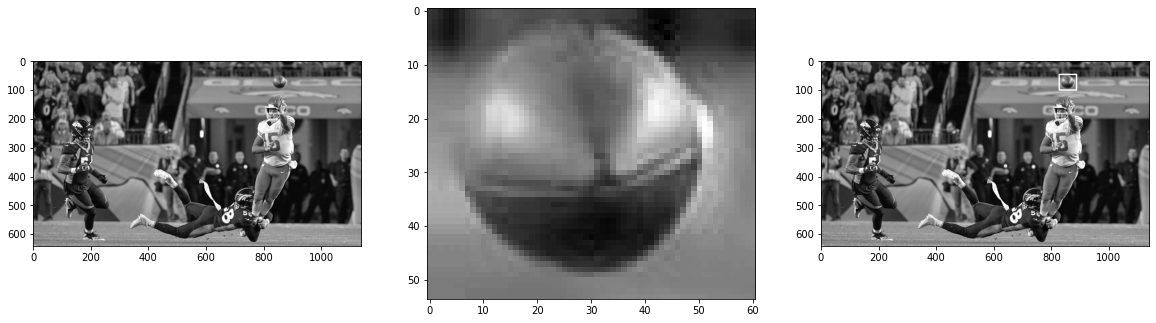

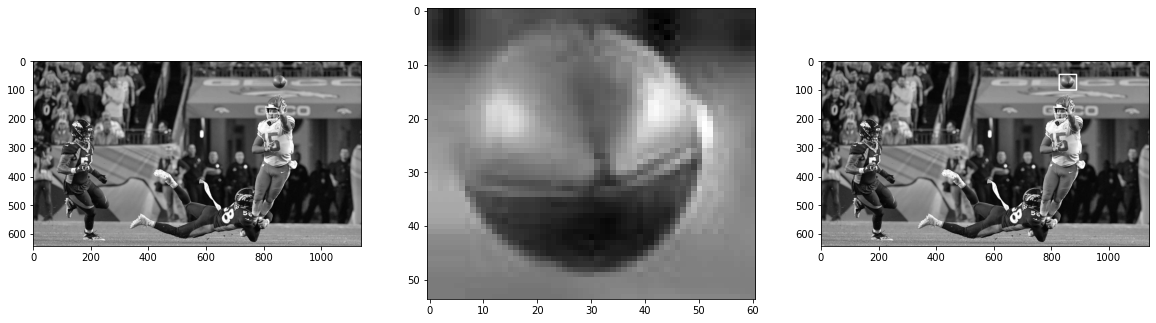

In [7]:
# Teste com a bola escura
img = plt.imread("images\MahomesPass.tiff")
obj = plt.imread("images\FootballBallDark.tiff")
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(obj, 'gray')
result = search_object("images\MahomesPass.tiff", "images\FootballBallDark.tiff", "escuro")
plt.subplot(1,3,3)
plt.imshow(result, 'gray')

# Teste com a bola clara
img = plt.imread("images\MahomesPass.tiff")
obj = plt.imread("images\FootballBallLighter.tiff")
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(obj, 'gray')
result = search_object("images\MahomesPass.tiff", "images\FootballBallLighter.tiff", "claro")
plt.subplot(1,3,3)
plt.imshow(result, 'gray')

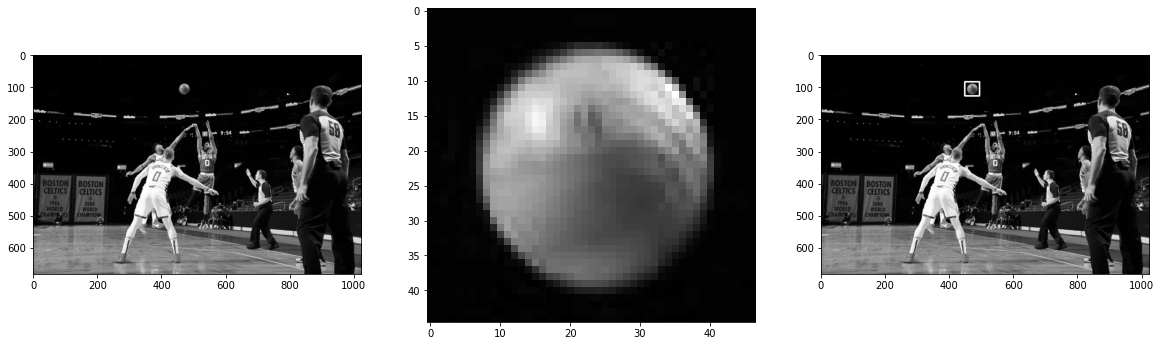

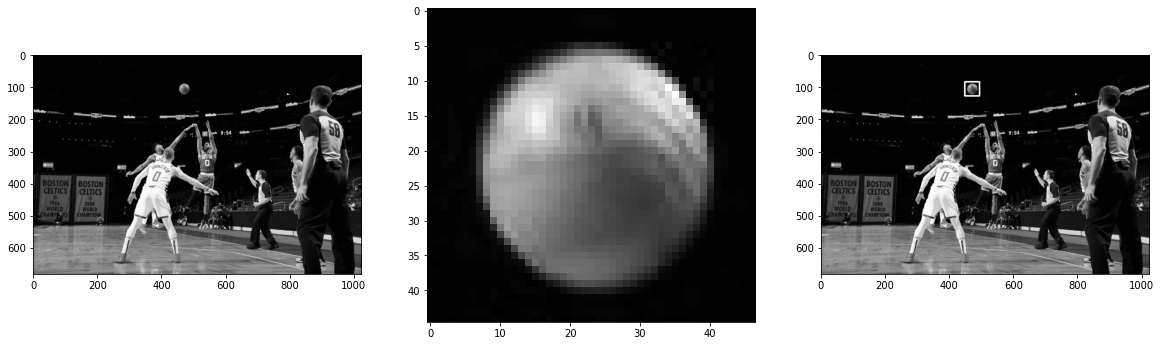

In [8]:
# Teste com a bola escura
img = plt.imread("images\TatumShot.tiff")
obj = plt.imread("images\BasketballBallDark.tiff")
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(obj, 'gray')
result = search_object("images\TatumShot.tiff", "images\BasketballBallDark.tiff", "escuro")
plt.subplot(1,3,3)
plt.imshow(result, 'gray')

# Teste com a bola clara
img = plt.imread("images\TatumShot.tiff")
obj = plt.imread("images\BasketballBallLighter.tiff")
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(obj, 'gray')
result = search_object("images\TatumShot.tiff", "images\BasketballBallLighter.tiff", "claro")
plt.subplot(1,3,3)
plt.imshow(result, 'gray')

## Efeitos colaterais

Nem tudo são flores. A nossa função recebe um parâmetro *dica* que diz se o objeto está mais escuro/claro que a imagem. Isso porque a transformação gamma pode escurecer tanto uma imagem a ponto de ela combinar mais com outro fundo que não seja o objeto. Dessa forma, deve-se ficar atento ao nível gama de transformação, escolhendo aquele que melhor se encaixa. A seguir há uma demonstração caso realizemos o procedimento para múltiplos valores gamma, no qual é possível observar que o objeto retornado nao é o desejado, marcando a calça do jogador do Milwaukee (Branco).

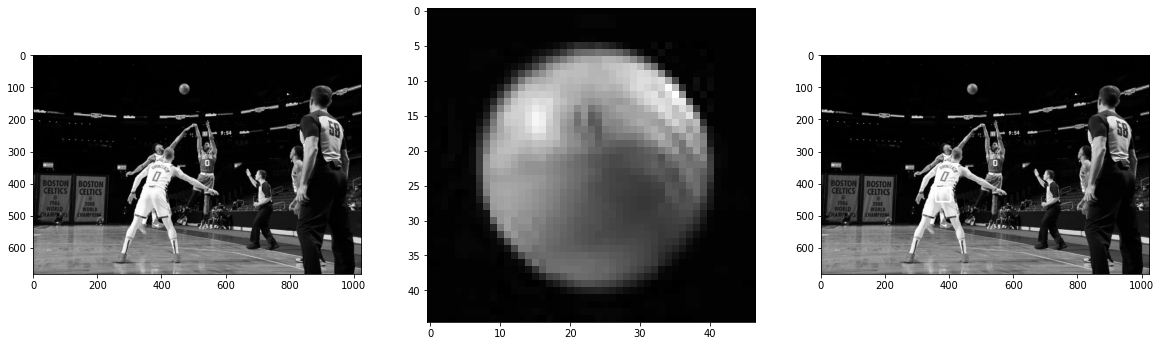

In [9]:
# Teste com a bola clara
img = plt.imread("images\TatumShot.tiff")
obj = plt.imread("images\BasketballBallLighter.tiff")
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.subplot(1,3,2)
plt.imshow(obj, 'gray')
result = search_object("images\TatumShot.tiff", "images\BasketballBallLighter.tiff", "ambos")
plt.subplot(1,3,3)
plt.imshow(result, 'gray')